# 

# Case Study: Exploratory Data Analysis

In this chapter, we demonstrate a short exploratory analysis as a case
study. This case study focuses on COVID-19 cases and deaths during 2020
using the `covidcases` and `mobility` datasets from the **HDSinRdata**
package. A new package that is used in this case study is **usmap**
package \[@R-usmap\], which allows us to easily create spatial plots of
the United States.

In [ ]:
library(HDSinRdata)
library(tidyverse)
library(patchwork)
library(gt)
library(gtsummary)
library(usmap)

## Preprocessing

We start by cleaning and merging our data. The `covidcases` data
contains weekly confirmed COVID-19 cases and deaths at the state and
county level in 2020. As the data description notes, some of these
values may be negative due to data discrepancies in the cumulative
counts data. The `mobility` data contains daily mobility statistics by
state.

In [ ]:
# Read in data
data(covidcases)
data(mobility)

First, we look at the columns in our data. We convert the date columns
in the mobility data to be recognized as a date using the `as.Date()`
function. The `covidcases` data has the week number of 2020. We create a
similar column for the mobility data.

In [ ]:
# Convert to date format and find week
mobility$date <- as.Date(mobility$date, formula = "%Y-%M-%D")
mobility$week <- week(mobility$date)

This allows us to summarize the mobility for a state across each week.

In [ ]:
# Find average mobility for week
mobility_week <- mobility %>%
  group_by(state, week) %>%
  summarize(m50 = mean(m50, na.rm=TRUE), .groups = "drop") 
head(mobility_week)

# A tibble: 6 × 3
  state    week   m50
  <chr>   <dbl> <dbl>
1 Alabama     9 13.2 
2 Alabama    10 14.6 
3 Alabama    11 13.4 
4 Alabama    12  8.98
5 Alabama    13  7.81
6 Alabama    14  6.73

For both of our datasets, we want to check whether each state was
observed across all dates and how the state’s name is represented. For
the mobility data, our data is at the state level so we can use the
`table()` function.

In [ ]:
# Find number of dates recorded for each state
table(mobility_week$state)


         Alabama           Alaska          Arizona         Arkansas 
              27               27               27               27 
      California         Colorado      Connecticut         Delaware 
              27               27               27               27 
         Florida          Georgia           Hawaii            Idaho 
              27               27               27               27 
        Illinois          Indiana             Iowa           Kansas 
              27               27               27               27 
        Kentucky        Louisiana            Maine         Maryland 
              27               27               27               27 
   Massachusetts         Michigan        Minnesota      Mississippi 
              27               27               27               27 
        Missouri          Montana         Nebraska           Nevada 
              27               27               27               27 
   New Hampshire       New Jersey

For the `covidcases` data, our data is at the county level. We need to
summarize the data instead. In this case, some states were observed for
fewer weeks than others.

In [ ]:
# Find state names and number of weeks recorded for each state
unique(covidcases$state)

 [1] "Alabama"              "Alaska"               "Arizona"             
 [4] "Arkansas"             "California"           "Colorado"            
 [7] "Connecticut"          "Delaware"             "District of Columbia"
[10] "Florida"              "Georgia"              "Hawaii"              
[13] "Idaho"                "Illinois"             "Indiana"             
[16] "Iowa"                 "Kansas"               "Kentucky"            
[19] "Louisiana"            "Maine"                "Maryland"            
[22] "Massachusetts"        "Michigan"             "Minnesota"           
[25] "Mississippi"          "Missouri"             "Montana"             
[28] "Nebraska"             "Nevada"               "New Hampshire"       
[31] "New Jersey"           "New Mexico"           "New York"            
[34] "North Carolina"       "North Dakota"         "Ohio"                
[37] "Oklahoma"             "Oregon"               "Pennsylvania"        
[40] "Rhode Island"         "South Car

    state             num_weeks   
 Length:51          Min.   :23.0  
 Class :character   1st Qu.:25.5  
 Mode  :character   Median :26.0  
                    Mean   :26.0  
                    3rd Qu.:27.0  
                    Max.   :27.0  

Note that D.C. is written differently for each data source. We update
this name in the mobility data.

In [ ]:
mobility_week$state[mobility_week$state == "Washington, D.C."] <- 
  "District of Columbia"

After checking the formatting of the `state` and `week` columns, we can
now merge our data together. In this case, we want to add the mobility
data to the case data and use a `left_join()`.

In [ ]:
# Join cases and mobility data
covid <- left_join(covidcases, mobility_week, by = c("state", "week"))

Next, we want to get some simple information about the continuous
variables in our data. We observe two key points. First, we can see the
negative values the data description warned us about, and second, there
is no missing data.

In [ ]:
summary(covid[, c("weekly_cases", "weekly_deaths", "m50")])

  weekly_cases      weekly_deaths          m50          
 Min.   : -190.00   Min.   :-511.00   Min.   : 0.02343  
 1st Qu.:    3.00   1st Qu.:   0.00   1st Qu.: 5.03029  
 Median :   10.00   Median :   1.00   Median : 7.73905  
 Mean   :   80.28   Mean   :   5.36   Mean   : 7.69445  
 3rd Qu.:   36.00   3rd Qu.:   3.00   3rd Qu.: 9.90145  
 Max.   :30584.00   Max.   :4416.00   Max.   :49.36699  

These negative numbers are clear data discrepancies. When showing the
distribution of cases in our exploratory analysis we may choose to
either code these as 0 or NA. We decide to recode these negative values
as NA.

In [ ]:
# Set negative counts to NA
covid$weekly_cases <- replace(covid$weekly_cases, 
                                   which(covid$weekly_cases < 0),
                                   NA)

covid$weekly_deaths <- replace(covid$weekly_deaths, 
                                   which(covid$weekly_deaths < 0),
                                   NA)

As the last step in our pre-processing, we add in the state abbreviation
and region for each state using the `state.name` and `state.region`
vectors available in R. We code D.C. to be in the same region as
Maryland and Virginia.

In [ ]:
# Add region and abbreviation and remove county
region_key <- data.frame(state = c(state.name, 
                                   "District of Columbia"), 
                         state_abb = c(state.abb, "DC"),
                         region = c(as.character(state.region), 
                                    "South"))

covid <- covid %>%
  left_join(region_key, by = c("state")) 

head(covid)

# A tibble: 6 × 8
  state   county   week weekly_cases weekly_deaths   m50 state_abb region
  <chr>   <chr>   <dbl>        <int>         <int> <dbl> <chr>     <chr> 
1 Alabama Autauga    12            3             0  8.98 AL        South 
2 Alabama Autauga    13            3             0  7.81 AL        South 
3 Alabama Autauga    14            2             1  6.73 AL        South 
4 Alabama Autauga    15           11             1  6.50 AL        South 
5 Alabama Autauga    16            5             1  7.53 AL        South 
6 Alabama Autauga    17            8             2  8.29 AL        South 

## Mobility and Cases Over Time

Now that our data are merged and cleaned, we start exploring mobility
and cases by region. The following summary table shows that these
measures did differ by region overall.

In [ ]:
covid %>%
  select(c("region", "m50", "weekly_cases", "weekly_deaths")) %>%
  tbl_summary(by = "region", missing = "no") %>%
  as_gt()

We then plot mobility over time both for the whole country and by
region. Across the country we see a similar pattern in how mobility
fluctuated but that certain regions had overall higher mobility than
others.

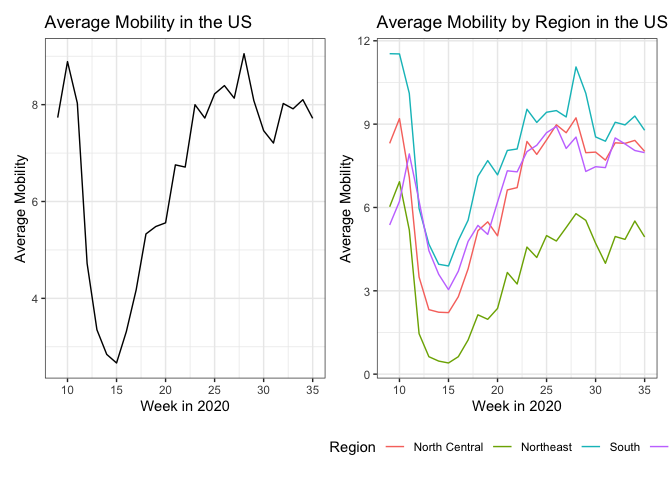

In [ ]:
# Average mobility in the US over time - overall 
pmob1 <- covid %>%
  select(c(region, state, week, m50)) %>%
  distinct() %>%
  group_by(week) %>%
  summarize(avg_m50 = mean(m50, na.rm=TRUE), .groups="drop") %>%
  ggplot() + 
  geom_line(aes(x = week, y = avg_m50)) +
  labs(x = "Week in 2020", y = "Average Mobility", 
       title = "Average Mobility in the US") + 
  theme_bw()

# Average mobility in the US over time - by region
pmob2 <- covid %>%
  select(c(region, state, week, m50)) %>%
  distinct() %>%
  group_by(region, week) %>%
  summarize(avg_m50 = mean(m50, na.rm=TRUE), .groups="drop") %>%
  ggplot() + 
  geom_line(aes(x = week, y = avg_m50, color = region)) +
  labs(x = "Week in 2020", y = "Average Mobility", 
       title = "Average Mobility by Region in the US",
       color = "Region") + 
  theme_bw() +
  theme(legend.position = "bottom") 

pmob1+pmob2

We then look at cases and deaths by region. A limitation of these data
are that we do not have population counts which would allow us to
standardize these numbers. However, we do use a secondary y-axis using
the `sec_axis()` function within `scale_y_continuous()` to allow us to
plot deaths and cases together. In this case, the secondary axis is
scaled by 1/10th of the primary axis.

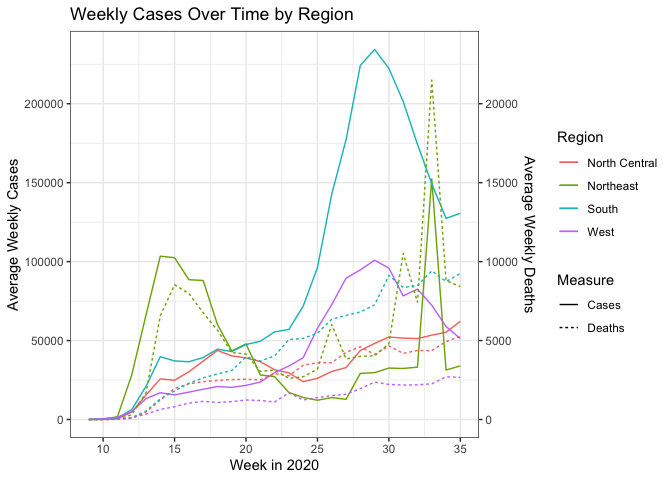

In [ ]:
# Change in number cases over time, per region
covid %>%
  filter(!is.na(region)) %>% 
  group_by(region, week) %>%
  summarize(weekly_cases = sum(weekly_cases, na.rm = TRUE),
            weekly_deaths = sum(weekly_deaths, na.rm = TRUE),
            .groups = "drop") %>%
ggplot() +
  geom_line(aes(x = week, y = weekly_cases, color = region, 
                linetype = "Cases")) + 
  geom_line(aes(x = week, y = weekly_deaths*10, color = region, 
                linetype = "Deaths")) +
  scale_y_continuous(name = "Average Weekly Cases",
                     sec.axis = sec_axis(~./10, 
                          name = "Average Weekly Deaths"))+
  scale_linetype(name = "Measure") +
  labs(x = "Week in 2020", color = "Region", 
       title = "Weekly Cases Over Time by Region") +
  theme_bw()

To look at how mobility and cases are related, we look at a scatter plot
of mobility and cases in California.

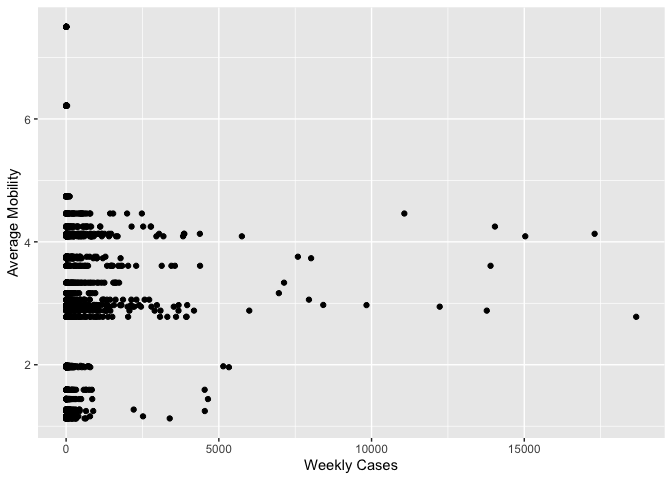

In [ ]:
covid_ca <- covid %>% filter(state == "California")
ggplot(covid_ca)+
  geom_point(aes(x = weekly_cases, y = m50), na.rm = TRUE) +
  labs(x = "Weekly Cases", y = "Average Mobility")

This motivates us to look at the correlation between these two columns
by state. We plot this using the `plot_usmap()` function from the
**usmap** package. Interestingly, we observe different relationships
throughout the country, but none of the correlations are particularly
strong.

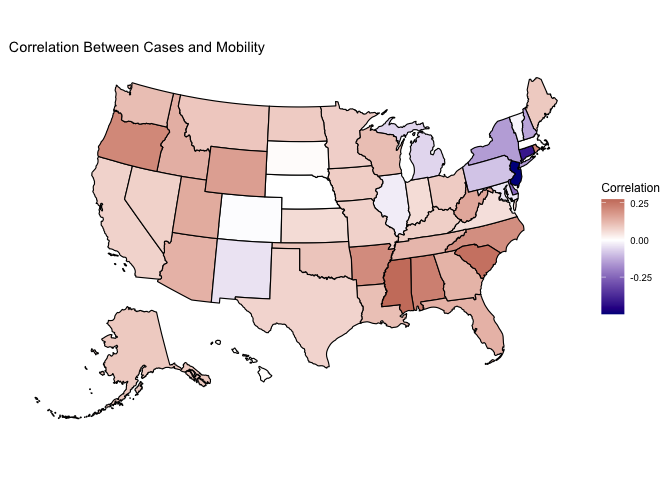

In [ ]:
# Calculate and plot correlation between cases and mobility, y state
covid_cor <- covid %>%
  group_by(state) %>%
  summarize(correlation = cor(weekly_cases, m50,
                              use = "complete.obs"))

plot_usmap(regions = "states", data = covid_cor, 
           values = "correlation") +
  scale_fill_gradient2(low = "darkblue", high = "darkred", 
                       mid="white", name = "Correlation") + 
  labs(title = "Correlation Between Cases and Mobility") +
  theme(legend.position = "right")

Last, we look at how the total cases and deaths are related to each
other. This shows that the Northeast suffered more deaths per case
overall, which may be related to the lower mobility and negative
correlation between mobility and cases observed earlier.

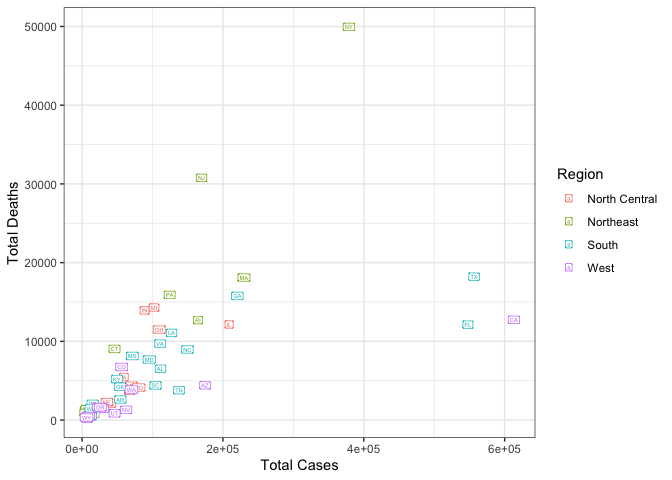

In [ ]:
# Relationship between cases and deaths summarized
covid %>%
  group_by(region, state_abb) %>%
  summarize(total_cases = sum(weekly_cases, na.rm = TRUE),
            total_deaths = sum(weekly_deaths, na.rm = TRUE),
            .groups = "drop") %>%
ggplot() + 
  geom_label(aes(x = total_cases, y = total_deaths, color = region,
                 label = state_abb), size = 1.5) + 
  labs(x = "Total Cases", y = "Total Deaths", color = "Region") +
  theme_bw()